<a href="https://colab.research.google.com/github/vgutierrezmendivil/SupervisedML/blob/main/Vicky_02_Supervisado_2023_UdeSA_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Supervisado I
# UdeSA, 2023
## Profesores: Marcela Svarc, Juan Manuel Pérez


## Taller 2: KNN + SVM + Validación cruzada


**Sin entrega**

Basado en el los labs del [ISLP](https://github.com/intro-stat-learning/ISLP_labs/tree/main).


In [ ]:
!pip install ISLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 7.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e9d72c0ce3b9cdcf6e3d488af3a41dc689a9355ad7e5c9aa6dfd1526a2924717
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstall

In [ ]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table


In [ ]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay


## Support Vector Classifier

Ahora usamos la función `SupportVectorClassifier()` (abreviada `SVC()`) de `sklearn` para entrenar el clasificador.

En `SVC` tenemos un argumento `C` que nos permite especificar el costo de una infracción para
el margen.

Si `C` es pequeño, entonces el margen será grande y muchos vectores de soporte estarán en el margen o van a violar el margen (mucha regularización). Si `C` es grande, entonces el margen será estrecho y habrá pocos vectores de apoyo.

Veamos un ejemplito de juguete para entender mejor cómo funciona esto.



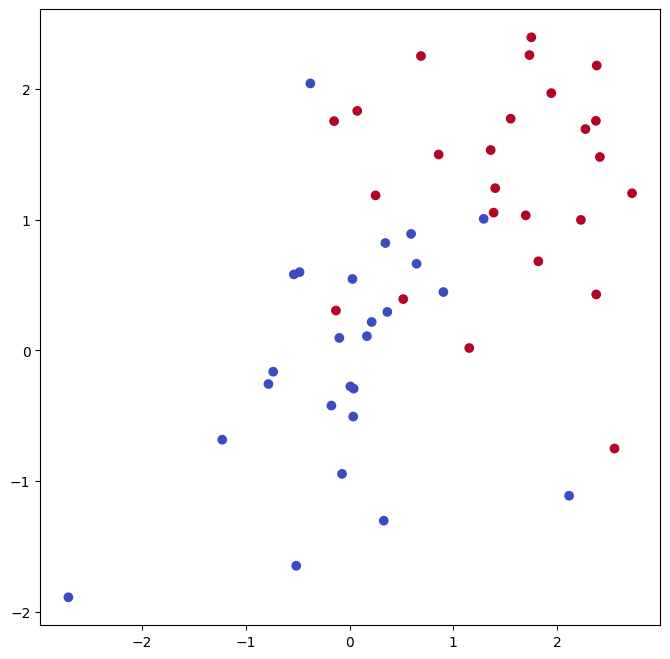

In [ ]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1.5
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);


No es linalmente separable

Vamos a usar la función `plot_svm` para visualizar el clasificador SVM con diferentes valores de `C`.


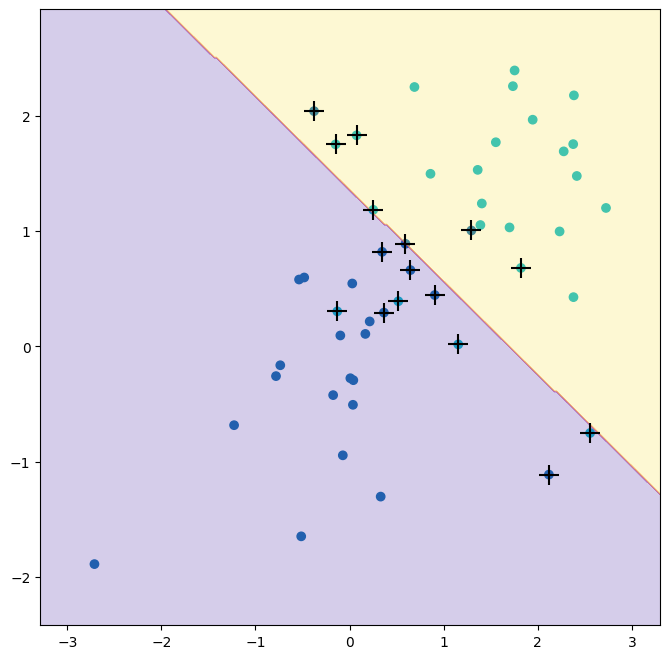

In [ ]:
from sklearn.svm import SVC

svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)


fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear,
         ax=ax)


El límite de decisión entre las dos clases es lineal (porque usamos el argumento `kernel='lineal'`). Los vectores de soporte están marcados con "+" y las observaciones restantes se trazan como círculos.

¿Qué pasaría si en lugar de eso usamos un valor menor del parámetro de costo?

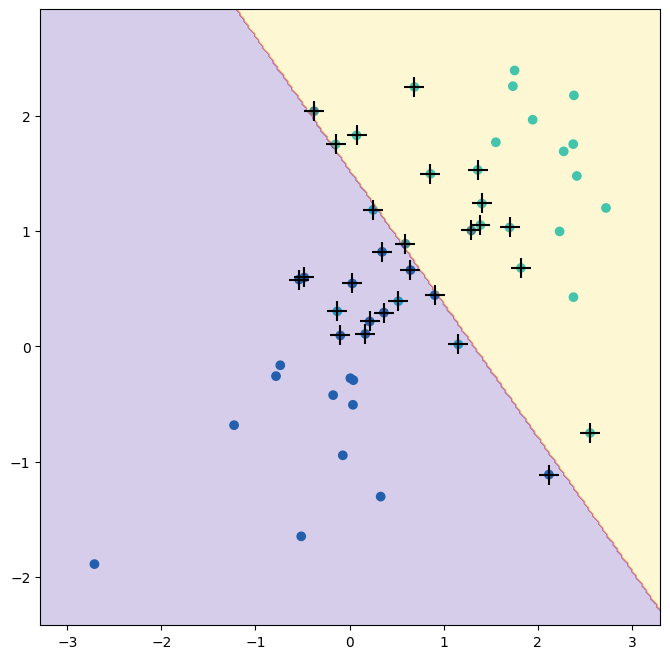

In [ ]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear_small,
         ax=ax)


Con un valor menor del parámetro de costo, obtenemos un mayor número de vectores de soporte, porque el margen ahora es más amplio. Podemos ver los coeficientes del modelo con:

In [ ]:
svm_linear.coef_


array([[1.03104255, 1.28604095]])

## Fronteras no lineales

De la misma manera que en el caso de regresión lineal, podemos ``extender'' el modelo lineal para que sea no lineal. En este caso, podemos usar una transformación no lineal de los predictores y luego ajustar un modelo lineal en los nuevos predictores transformados (por ejemplo, cuando agregamos $X^2$ como un predictor adicional en la regresión lineal simple).

Una idea muy similar se utiliza en el contexto de los modelos de SVM. Sin embargo, la transformación no lineal se realiza implícitamente mediante el uso de un kernel. Un kernel nos permite construir un clasificador SVM con un límite de decisión no lineal. Hay varios tipos de kernels

- lineal (el estándar)
- polinomial
- radial

El kernel radial es uno de los más populares, y tiene la forma

$$K(x_1, x_2) = \exp(-\gamma \| x_1 - x_2 \|^2)$$

Gamma es un parámetro que controla la flexibilidad del kernel. Un gamma más alto hace que el valor del kernel decaiga más rápido, lo que significa que los puntos más lejanos tienen menos influencia entre sí.

Ver la [documentación de sklearn](https://scikit-learn.org/stable/modules/svm.html#kernel-functions) para más detalles.


Veamos un ejemplo de juguete para entender mejor cómo funciona esto.


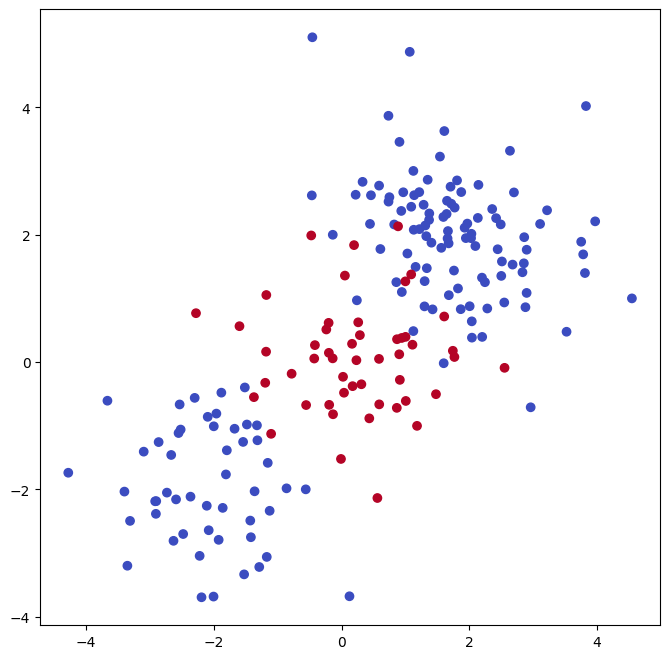

In [ ]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm)


Claramente, es no lineal.

Partimos en train y test, 50% y 50%, y entrenamos un modelo SVM con kernel radial.

In [ ]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)



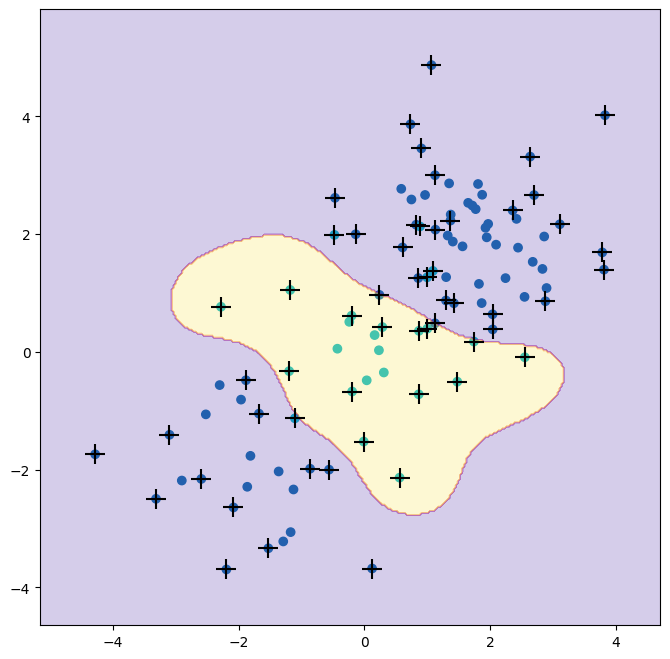

In [ ]:

svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)


Podemos observar que hay unos cuantos errores. ¿Y si subimos `C` un poco?


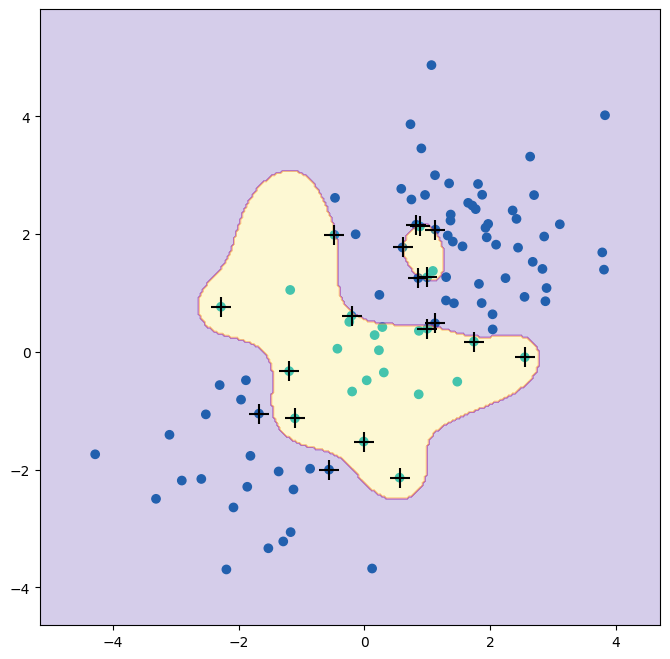

In [ ]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)


No queda muy claro qué valor de `C` es el mejor. ¿Cómo podemos elegirlo?

Usemos K-fold cross-validation para elegir `C` y `gamma`, mediante `GridSearchCV`.

Hay varias formas de seleccionar hiperparámetros:

- Grid search: probar todas las combinaciones posibles de valores de hiperparámetros.
- Random search: probar un número aleatorio de combinaciones de valores de hiperparámetros.
- Métodos bayesianos: probar un número de combinaciones de valores de hiperparámetros, y luego usar los resultados para elegir nuevas combinaciones de valores de hiperparámetros.

En este caso, vamos a usar grid search.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

kfold = skm.KFold(5,
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_


{'C': 100, 'gamma': 0.5}

Truth,1,2
Predicted,,
1,71,3
2,4,22


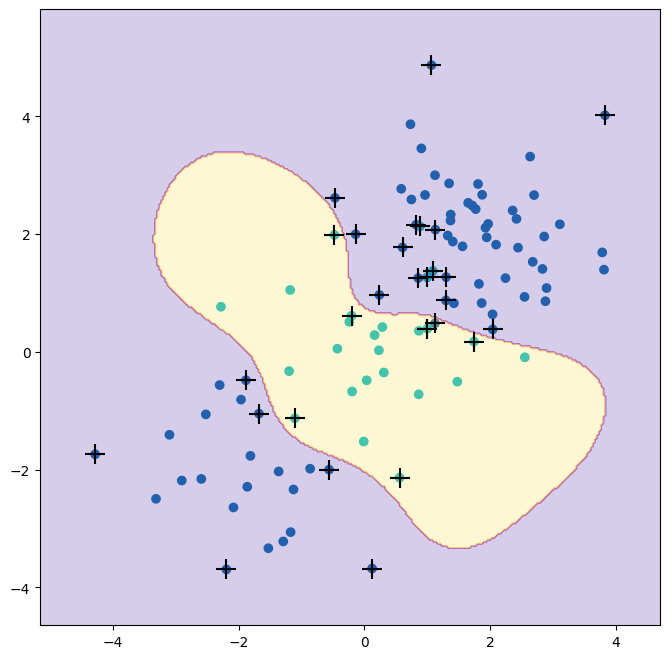

In [ ]:
best_svm = grid.best_estimator_
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_svm,
         ax=ax)

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)


¿Qué accuracy tuvo?

**NOTA**: Recordar que esto no es lo ideal: deberíamos haber partido en train, validation y test. Pero para este ejemplo, vamos a usar sólo train y test.

## SVM en el dataset Iris

Vamos a usar SVM para clasificar las flores del dataset Iris.


In [ ]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target

df = pd.DataFrame(X, columns=[x.strip(" (cm)") for x in iris.feature_names])
df["species"] = [iris.target_names[x] for x in y]
df


In [ ]:
# Train / test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)



In [ ]:
from sklearn.metrics import classification_report
svm = SVC(kernel="linear", gamma=1, C=1)

svm_rbf.fit(X_train, y_train)

y_pred = svm_rbf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

## Ejercicio 1

Cargar el dataset de cáncer de mama de sklearn con SVM.
- Partir en train y test
- Elegir sobre train la mejor combinación de hiperparámetros para el kernel radial usando GridSearchCV
- Evaluar sobre test

¿Qué combinación de hiperparámetros da el mejor resultado?

Probar también KNN, LDA y QDA.

In [ ]:
# Cargar dataset de cancer de mama

from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

df = pd.DataFrame(X, columns=cancer.feature_names)

df